In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
from atl_module import kriging
import geopandas as gpd
from atl_module import GebcoUpscaler
import rasterio as rio
from shapely.geometry import box

In [3]:
jarkuspts = gpd.read_file("../data/jarkus/jarkus-2021_Noord-Holland.gpkg")

In [4]:
jarkuspts = jarkuspts.assign(X=jarkuspts.geometry.x, Y=jarkuspts.geometry.y)

In [5]:
truth = rio.open("../data/special_sites/petten/in-situ-DEM/truth.vrt")
truthrascrs = truth.crs
truth_ras_bounds = box(*truth.bounds)

In [6]:
subset_jarkus = (
    jarkuspts.to_crs(truthrascrs)
    .clip(truth_ras_bounds)
    .to_crs(jarkuspts.estimate_utm_crs())
)
# add the location in local UTM system as a columns
subset_jarkus = subset_jarkus.assign(
    northing=subset_jarkus.geometry.y,
    easting=subset_jarkus.geometry.x,
    sf_elev_MSL=subset_jarkus.geometry.z,
).loc[:, ["X", "Y", "northing", "easting", "sf_elev_MSL", "geometry"]]
sub_jarkus = subset_jarkus[subset_jarkus.sf_elev_MSL < 1]

In [7]:
subset_jarkus.to_file("../data/special_sites/petten/all_bathy_pts.gpkg")

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [8]:
site = GebcoUpscaler(
    "../data/special_sites/petten",
    "Petten",
    "../data/special_sites/petten/in-situ-DEM/truth.vrt",
)

In [9]:
site.subset_gebco(50)

[D 220930 17:59:14 raster_interaction:149] GEBCO subset raster written to ../data/special_sites/petten/bilinear.tif, with CRS EPSG:32631


In [10]:
# %%time
# site.kriging(
#     kr_model="uk",
#     npts=2000,
#     variogram_parameters={"range": 10000, "nugget": 0.7, "sill": 23},
#     samplemethod="dart",
# )

In [11]:
site.kalman_update(1.5)
site.raster_rmse(check_kriged=True)
site.write_raster_error_tables()

[I 220930 17:59:14 kalman:72] Wrote Kalman Updated Raster with GEBCO uncertainty 1.5 to ../data/special_sites/petten/kalman_updated.tif
[I 220930 17:59:14 core:229] Sucessful Kalman update of GEBCO bathymetry for Petten using a gebco standard deviation of 1.5 saved to ../data/special_sites/petten/kalman_updated.tif
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:173: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(error_data**2)
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:175: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(error_data))
/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:176: RuntimeWarning: Mean of empty slice
  me = np.nanmean(error_data)
[I 220930 18:00:27 core:298] site:Petten - {"RMSE [m]":{"Naive Bilinear Interpolation":1.4757187466,"Kriged Raster":1.2156655822,"Kalman Updated Raster":0.9959420481},"MAE [m]":{"Naive Bilinear Interpolati

In [12]:
site.bathy_pts_gdf = site.bathy_pts_gdf.assign(easting_corr=0, northing_corr=0)
site.add_truth_data()

[I 220930 18:01:04 core:257] Truth data added to Bathymetric Points dataframe for site: Petten


In [13]:
site.lidar_error()

[I 220930 18:01:04 core:238] Petten: RMSE between icesat and truth 0.46928823888558663, MAE: 0.29491203201446353


,MAE,RMSE,Median Abs error,R2 Score,Average Error
Petten,0.294912,0.469288,0.145,0.995713,-0.038357


[I 220930 18:01:05 core:341] Petten: Saved lidar error plot to ../document/figures/Petten_lidar_estimated_vs_truth.pdf


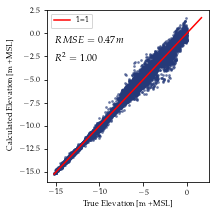

In [14]:
site.bathy_pts_gdf = site.bathy_pts_gdf[site.bathy_pts_gdf.true_elevation < 0]
fig = site.plot_lidar_error()

In [15]:
ax = fig.axes[0]
ax.set_xlabel("Elevation from Van Oord Survey [m +NAP]")
ax.set_ylabel("Jarkus Elevation [m +NAP]")
fig.tight_layout()
fig.savefig("../document/figures/Petten_lidar_estimated_vs_truth.pdf")

In [16]:
# site.bathy_pts_gdf = gpd.read_file('../data/special_sites/petten/kriging_pts/').rename(columns={'Z':'sf_elev_MSL'})
fig = site.plot_icesat_points(fraction=0.5, ratio=0.57)

TypeError: plot_icesat_points() got an unexpected keyword argument 'ratio'

In [ ]:
# remove the accreditdation text
ax = fig.axes[0]
text = ax.texts[0]
text.set_visible(False)

In [ ]:
fig.savefig("../document/figures/Petten_photon_map.pdf")